# Credit Card Fraud Detection Predictive Models
## Introduction
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

- Features V1, V2, ... V28 are the principal components obtained with PCA;
- The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
- Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.
## Load packages

In [1]:
# !pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3 psycopg2-binary 
# Docker image: katonic/usecase:1.0 / katonic/notebook-env:base

In [2]:
import os
# os.system("pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3")
os.system("pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3")

0

In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
# from pyspark.sql import SparkSession
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import DataFrame, SparkSession, Window
# from pyspark.sql.functions import col, expr, monotonically_increasing_id, row_number,current_timestamp
from typing import  List
from datetime import datetime
from io import StringIO
import joblib
from minio import Minio
from subprocess import run, Popen, PIPE

import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient

import psycopg2
import pandas as pd
from sqlalchemy import create_engine,text
from typing import Optional
import datetime as dt

In [4]:

from sqlalchemy import create_engine , text
from sklearn.feature_selection import RFECV
from typing import Optional
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime 
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from azure.storage.blob import BlockBlobService
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from hana_ml import dataframe

In [5]:
#!apt-get install build-dep python-psycopg2
#!pip install psycopg2-binary

In [6]:
# Ensure Minio access
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'BS6PpUKnW^Bkc@$l$QAsY$p#l'
os.environ['MLFLOW_BASE_URL'] = 'http://mlflow-service.mlflow.svc.cluster.local:5000'

# connect to remote server

mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])

# Launch the experiment on mlflow
experiment_name = "credit-card-fraud-detection"
mlflow.set_experiment(experiment_name)

exp_details = mlflow.get_experiment_by_name(experiment_name)
exp_id = exp_details.experiment_id

client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

In [7]:
pd.set_option('display.max_columns', 100)

In [8]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
IS_LOCAL = False

MINIO_HOST="minio-service.kubeflow:9000"
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="minio123"
MINIO_MODEL_BUCKET="seldon"

EVENT_TIMESTAMP_ALIAS = "event_timestamp"
CREATED_TIMESTAMP_ALIAS = "created_timestamp"

MODEL_NAME = "cred_fraud_detection-model"

#file_url = "https://raw.githubusercontent.com/katonic-dev/usecases/master/datasets/"
file_name = "dataset.csv"

In [9]:
POSTGRES_ADDRESS = '52.187.120.22' ## INSERT YOUR DB ADDRESS
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'katonic@47' ## CHANGE THIS TO YOUR POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_DBNAME = 'postgres' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_ENGINE = 'postgres'
PROJECT_NAME = 'katonic'
PROJECT_SCHEMA = 'demo_credit_fraud'
TABLE_TRAIN = 'credit_card_fraud_train'
TABLE_INFERENCE = 'credit_card_fraud_inference'
TABLE_PREPROCESS_TRAIN = 'credit_card_fraud_preprocess_train'
TABLE_PREPROCESS_INFERENCE = 'credit_card_fraud_preprocess_inference'

In [10]:
address='137.117.100.87'
port='39017'
user='system'
password='HXEHana1'

In [11]:
train = 0
inference = 1

In [12]:
def get_minio():
    return Minio(MINIO_HOST,
                    access_key=MINIO_ACCESS_KEY,
                    secret_key=MINIO_SECRET_KEY,
                    secure=False)

In [13]:
def passwrd_parser(POSTGRES_PASSWORD):
    POSTGRES_PASSWORD = POSTGRES_PASSWORD.replace("@","%40")
    return POSTGRES_PASSWORD

In [14]:
def write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,dataset,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    
    query = text(f""" 
                CREATE SCHEMA IF NOT EXISTS {PROJECT_SCHEMA} """)
    engine.execute(query)
    
    #query = text(f""" 
    #               DROP TABLE IF EXISTS  {PROJECT_SCHEMA}.{table} CASCADE;""")
    #engine.execute(query)
    dataset.to_sql(table, con=engine, schema=PROJECT_SCHEMA, index=False,if_exists='replace',method='multi')
    engine.dispose()
    

In [15]:
def read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    df = pd.read_sql('SELECT * FROM {0}.{1}'.format(PROJECT_SCHEMA, table), engine)
    engine.dispose()
    return df

#engine.dispose()    

In [16]:
minioClient = get_minio()
buckets = minioClient.list_buckets()
for bucket in buckets:
    print(bucket.name, bucket.creation_date)

mlpipeline 2021-07-06 07:22:22.863000+00:00
seldon 2021-07-06 07:22:20.971000+00:00


In [17]:
if not minioClient.bucket_exists(MINIO_MODEL_BUCKET):
    minioClient.make_bucket(MINIO_MODEL_BUCKET)

## Read the data

In [18]:
conn = dataframe.ConnectionContext(address,port,user,password)

In [19]:
if train:
    creditcard = dataframe.DataFrame(conn, 'select * from DEMO_CREDIT_CARD.CREDIT_CARD_TRAIN').collect()
elif inference:
    creditcard = dataframe.DataFrame(conn, 'select * from DEMO_CREDIT_CARD.CREDIT_CARD_INFERENCE').collect()
    creditcard.pop('index')
    
creditcard.pop('timestamp')
creditcard.shape

(2000, 32)

## Check the data

In [20]:
print("Credit Card Fraud Detection data -  rows:",creditcard.shape[0]," columns:", creditcard.shape[1])

Credit Card Fraud Detection data -  rows: 2000  columns: 32


In [21]:
creditcard['Class'].value_counts()

0    1987
1      13
Name: Class, dtype: int64

### Glimpse the data
We start by looking to the data features (first 5 rows).



In [22]:
#creditcard.iloc[:10000].to_csv("creditcardnew.csv", index=False)

In [23]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,10990.0,-0.978969,0.891371,2.319535,-0.366443,-0.064428,-0.701253,0.287479,-0.277378,0.889065,-0.888369,0.798601,-1.864867,3.342448,0.979710,0.285233,0.255232,0.251996,0.114434,-0.141915,0.023812,0.016648,0.289814,-0.354844,0.451382,0.146643,1.035808,-0.285715,0.067639,12.95,0,3.0
1,10990.0,1.187976,-0.150266,0.950144,0.273609,-1.008121,-0.668541,-0.633928,0.013531,1.685281,-0.308360,2.273145,-2.391213,0.201110,1.976253,0.025093,0.692488,0.202148,0.763696,-0.181124,-0.170890,-0.018174,0.099565,0.014798,0.512315,0.099670,1.006098,-0.102534,-0.005459,15.95,0,3.0
2,10991.0,-0.291467,0.848939,1.853259,0.057920,-0.438931,-0.597373,0.200133,-0.201451,1.101389,-0.656723,0.579345,-2.494774,2.182849,1.318407,0.637624,0.084044,0.503039,0.362604,0.402474,0.037224,0.076264,0.488248,-0.076796,0.429956,-0.734458,1.011073,-0.056456,0.145633,14.95,0,3.0
3,10991.0,-0.362454,0.475100,1.579593,-0.891771,0.006748,-0.451606,0.167889,0.042788,1.157205,-0.903576,1.668824,-2.240497,1.240255,1.612326,-0.823729,0.956849,-0.359215,0.912083,-0.606932,-0.130137,0.117070,0.479416,-0.026288,-0.006762,-0.877070,0.752055,0.061740,0.160531,15.95,0,3.0
4,10992.0,1.345316,-0.018177,0.290022,-0.006065,-0.125986,-0.026471,-0.449742,-0.126617,1.794592,-0.525465,-0.567849,-2.696546,2.284918,1.341292,0.655219,0.883889,-0.228953,0.581675,0.122653,-0.019355,-0.155716,-0.168735,-0.191035,-0.980377,0.402362,1.116657,-0.089681,-0.007732,15.95,0,3.0


Let's look into more details to the data.



In [24]:
creditcard.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,12710.729500,-0.022069,0.236042,0.933995,0.462084,-0.129832,0.042410,-0.246885,-0.042246,1.380253,-0.456009,1.273625,-2.257152,1.484241,1.244070,-0.374434,0.094068,0.479769,0.153572,-0.130680,-0.034232,-0.044849,-0.102336,-0.026068,0.003694,0.079557,0.448482,-0.034713,0.010225,54.074895,0.00650,3.211500
std,1335.898016,1.592876,1.402475,1.404181,1.409367,1.236303,1.237751,1.117687,0.919699,0.954894,1.104875,1.173766,1.157658,0.855029,1.461997,0.907428,1.020976,1.318848,0.783769,0.795305,0.521593,0.742599,0.525926,0.487527,0.564480,0.432201,0.600290,0.437662,0.224671,136.462722,0.08038,0.408474
min,10990.000000,-27.670569,-34.607649,-15.496222,-4.573540,-6.405551,-23.496714,-26.548144,-12.536217,-6.329801,-13.193415,-1.508465,-17.769143,-1.795346,-19.214325,-4.092344,-12.227189,-18.587366,-6.920762,-4.021062,-12.834042,-4.651023,-3.656983,-11.669994,-2.203341,-2.483069,-0.927447,-5.045247,-3.509250,0.000000,0.00000,3.000000
25%,11403.500000,-0.898314,-0.171496,0.546338,-0.228972,-0.675119,-0.555373,-0.584712,-0.161185,0.984294,-0.731871,0.476306,-2.554725,0.881596,1.126306,-0.979401,-0.326738,0.106362,-0.236074,-0.561120,-0.160696,-0.253926,-0.381592,-0.146239,-0.297266,-0.137238,-0.094776,-0.097327,-0.012915,9.990000,0.00000,3.000000
50%,12482.000000,0.692908,0.081607,0.936604,0.218670,-0.299903,-0.157068,-0.298609,0.006676,1.457406,-0.457715,1.253568,-2.149061,1.497243,1.474622,-0.160439,0.229687,0.449121,0.222504,-0.177743,-0.066389,-0.108272,-0.042791,-0.044523,0.047144,0.134637,0.632951,-0.063383,0.004838,15.950000,0.00000,3.000000
75%,14110.500000,1.189091,0.680509,1.637733,1.101421,0.214325,0.381765,0.171717,0.187524,1.774638,-0.251770,2.098561,-1.773947,2.102422,1.708442,0.258948,0.646020,0.908819,0.593591,0.322713,0.076234,0.003412,0.228584,0.053445,0.382913,0.352946,1.032810,0.034591,0.056011,39.000000,0.00000,3.000000
max,15012.000000,1.960497,8.636214,3.920275,10.463020,34.099309,10.033923,8.571717,5.060381,7.496577,6.899482,12.018913,0.408602,3.487528,3.211642,2.842023,3.162369,7.893393,4.115560,4.555359,3.573079,11.210748,1.498506,10.475770,2.192626,2.419792,2.833837,8.254376,3.854891,2126.130000,1.00000,4.000000


Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

### Check missing data
Let's check if there is any missing data.

In [25]:
total = creditcard.isnull().sum().sort_values(ascending = False)
percent = (creditcard.isnull().sum()/creditcard.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,Class,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V16,V15,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Hour
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.
### Data unbalance
Let's check data unbalance with respect with target value, i.e. Class.

In [26]:
#temp = creditcard["Class"].value_counts()
#df = pd.DataFrame({'Class': temp.index,'values': temp.values})
#
#trace = go.Bar(
#    x = df['Class'],y = df['values'],
#    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
#    marker=dict(color="Red"),
#    text=df['values']
#)
#data = [trace]
#layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
#          xaxis = dict(title = 'Class', showticklabels=True), 
#          yaxis = dict(title = 'Number of transactions'),
#          hovermode = 'closest',width=600
#         )
#fig = dict(data=data, layout=layout)
#iplot(fig, filename='class')

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

## Data exploration
#### Transactions in time

In [27]:
#class_0 = creditcard.loc[creditcard['Class'] == 0]["Time"]
#class_1 = creditcard.loc[creditcard['Class'] == 1]["Time"]
#
#hist_data = [class_0, class_1]
#group_labels = ['Not Fraud', 'Fraud']
#
#fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
#fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
#iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [28]:
creditcard['Time'] = creditcard['Time'].astype('float')
creditcard['Hour'] = creditcard['Time'].apply(lambda x: np.floor(x / 3600))

tmp = creditcard.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,3.0,0,0.0,1903.26,1564,83961.43,53.683779,15.95,16880.213911
1,3.0,1,0.0,179.66,13,220.05,16.926923,1.00,2457.208190
2,4.0,0,0.0,2126.13,423,23968.31,56.662671,15.95,25571.693464


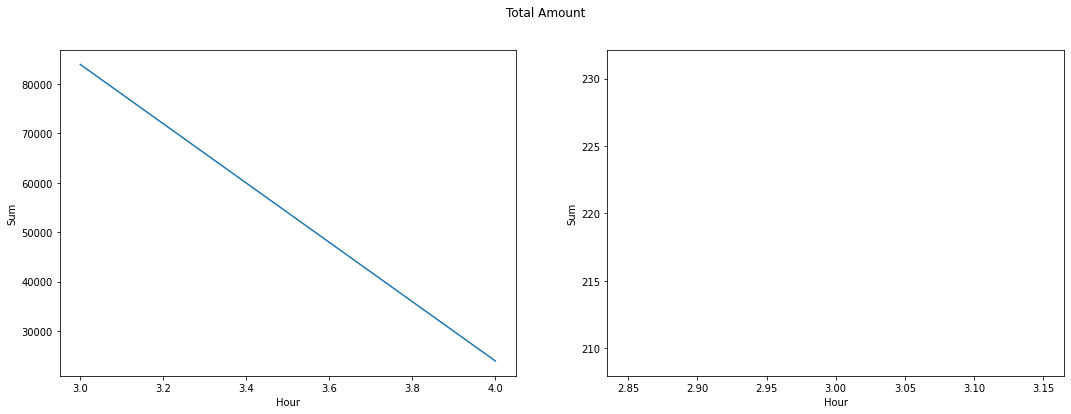

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

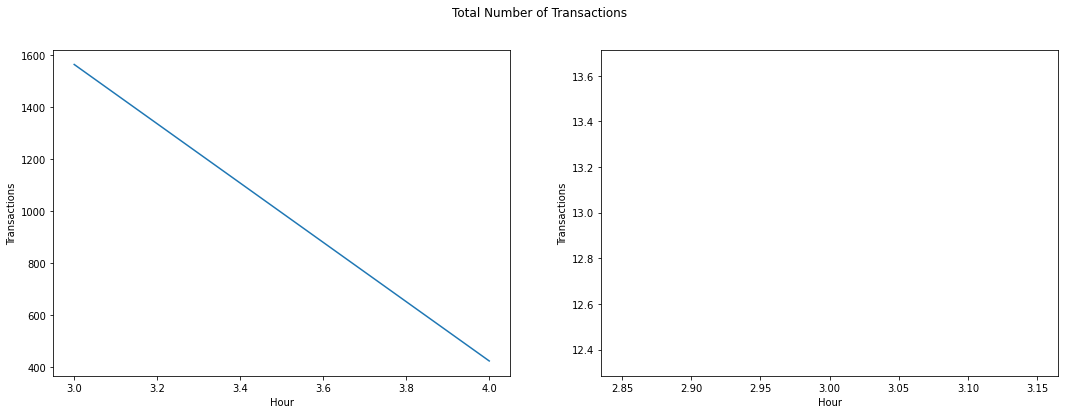

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

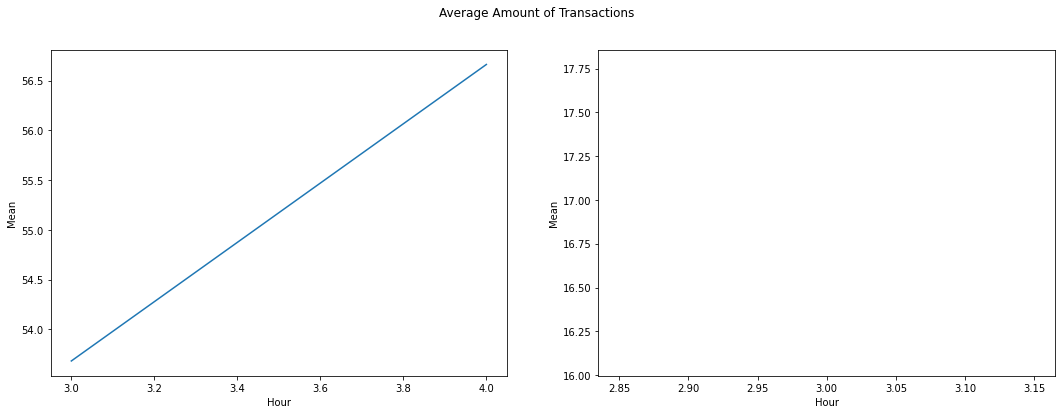

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

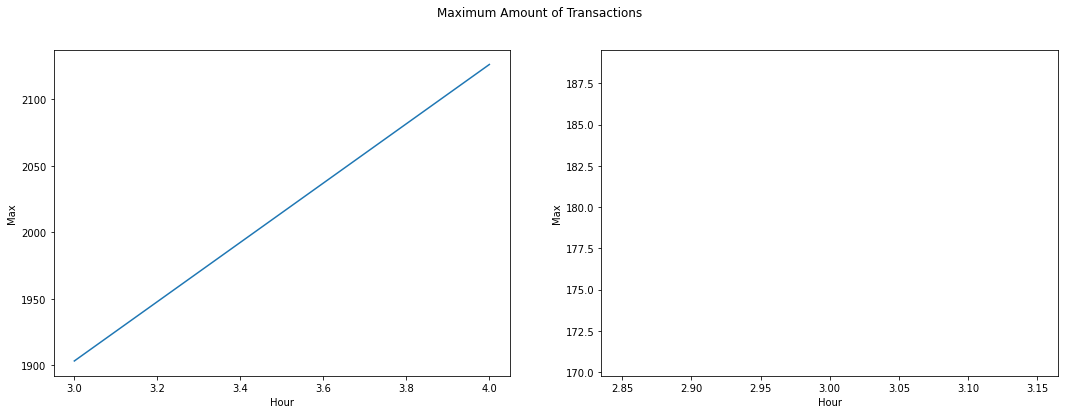

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

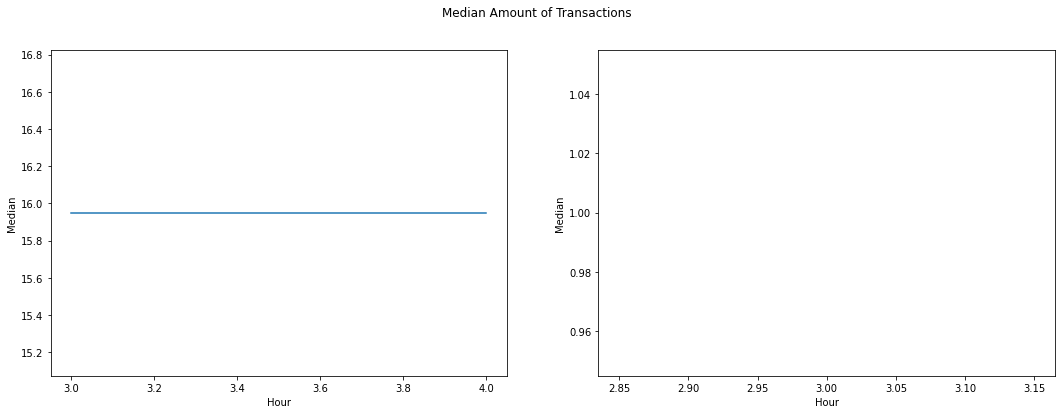

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

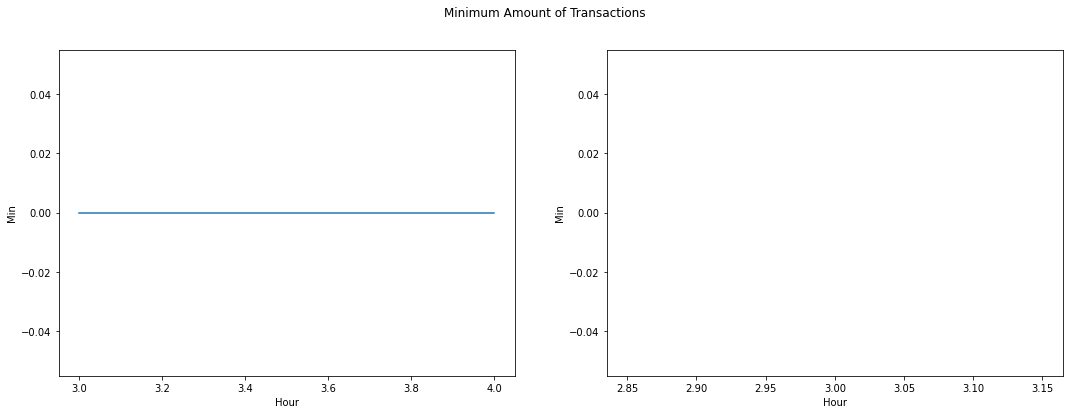

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

#### Transactions amount

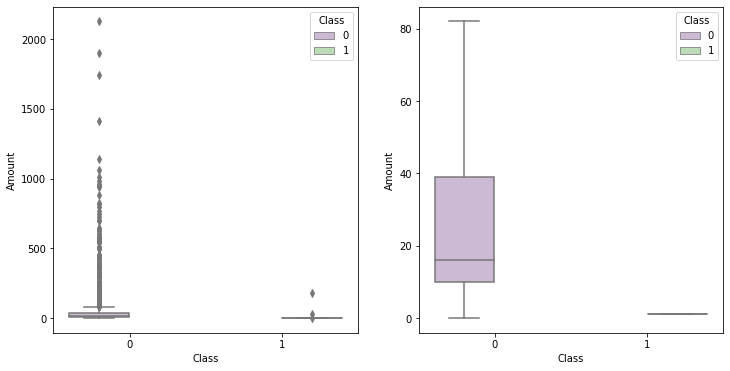

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=creditcard, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=creditcard, palette="PRGn",showfliers=False)
plt.show();

In [36]:
tmp = creditcard[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    1987.000000
mean       54.317937
std       136.821168
min         0.000000
25%         9.990000
50%        15.950000
75%        39.000000
max      2126.130000
Name: Amount, dtype: float64

In [37]:
class_1.describe()

count     13.000000
mean      16.926923
std       49.570235
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      179.660000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [38]:
# fraud = creditcard.loc[creditcard['Class'] == 1]

# trace = go.Scatter(
#     x = fraud['Time'],y = fraud['Amount'],
#     name="Amount",
#      marker=dict(
#                 color='rgb(238,23,11)',
#                 line=dict(
#                     color='red',
#                     width=1),
#                 opacity=0.5,
#             ),
#     text= fraud['Amount'],
#     mode = "markers"
# )
# data = [trace]
# layout = dict(title = 'Amount of fraudulent transactions',
#           xaxis = dict(title = 'Time [s]', showticklabels=True), 
#           yaxis = dict(title = 'Amount'),
#           hovermode='closest'
#          )
# fig = dict(data=data, layout=layout)
# iplot(fig, filename='fraud-amount')

#### Features correlation

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

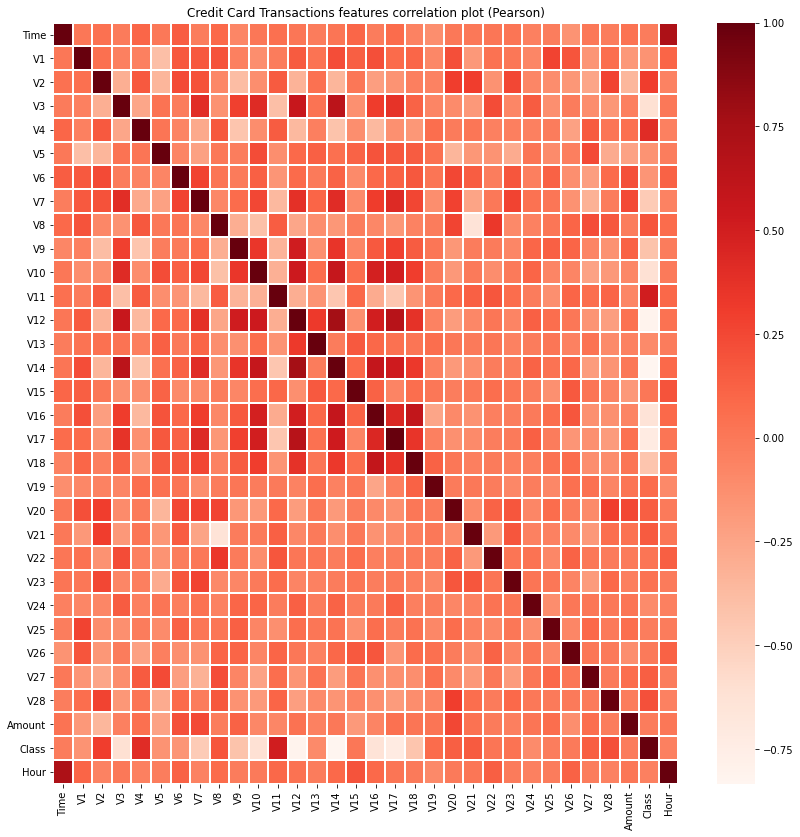

In [39]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = creditcard.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

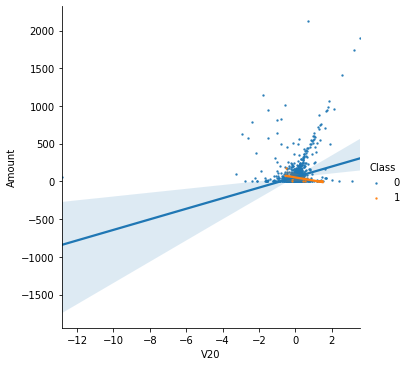

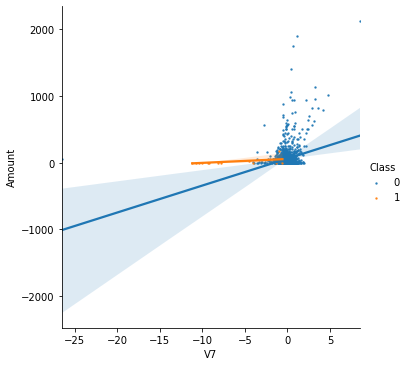

In [40]:
s = sns.lmplot(x='V20', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

Let's plot now the inverse correlated values.

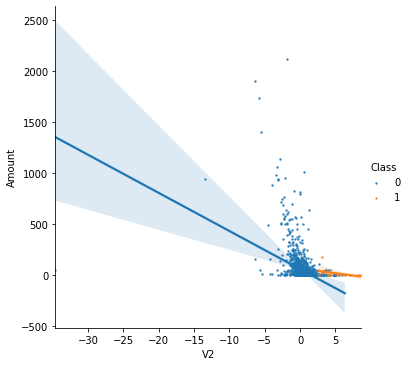

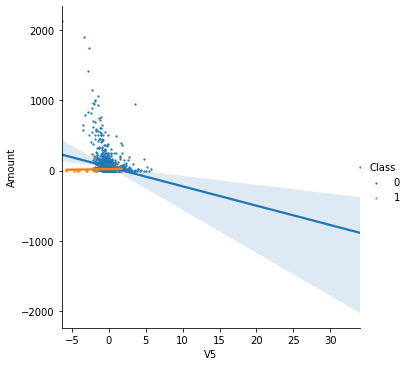

In [41]:
s = sns.lmplot(x='V2', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

#### Features density plot

In [42]:
creditcard['V1'] = creditcard['V1'].astype('float')

<Figure size 432x288 with 0 Axes>

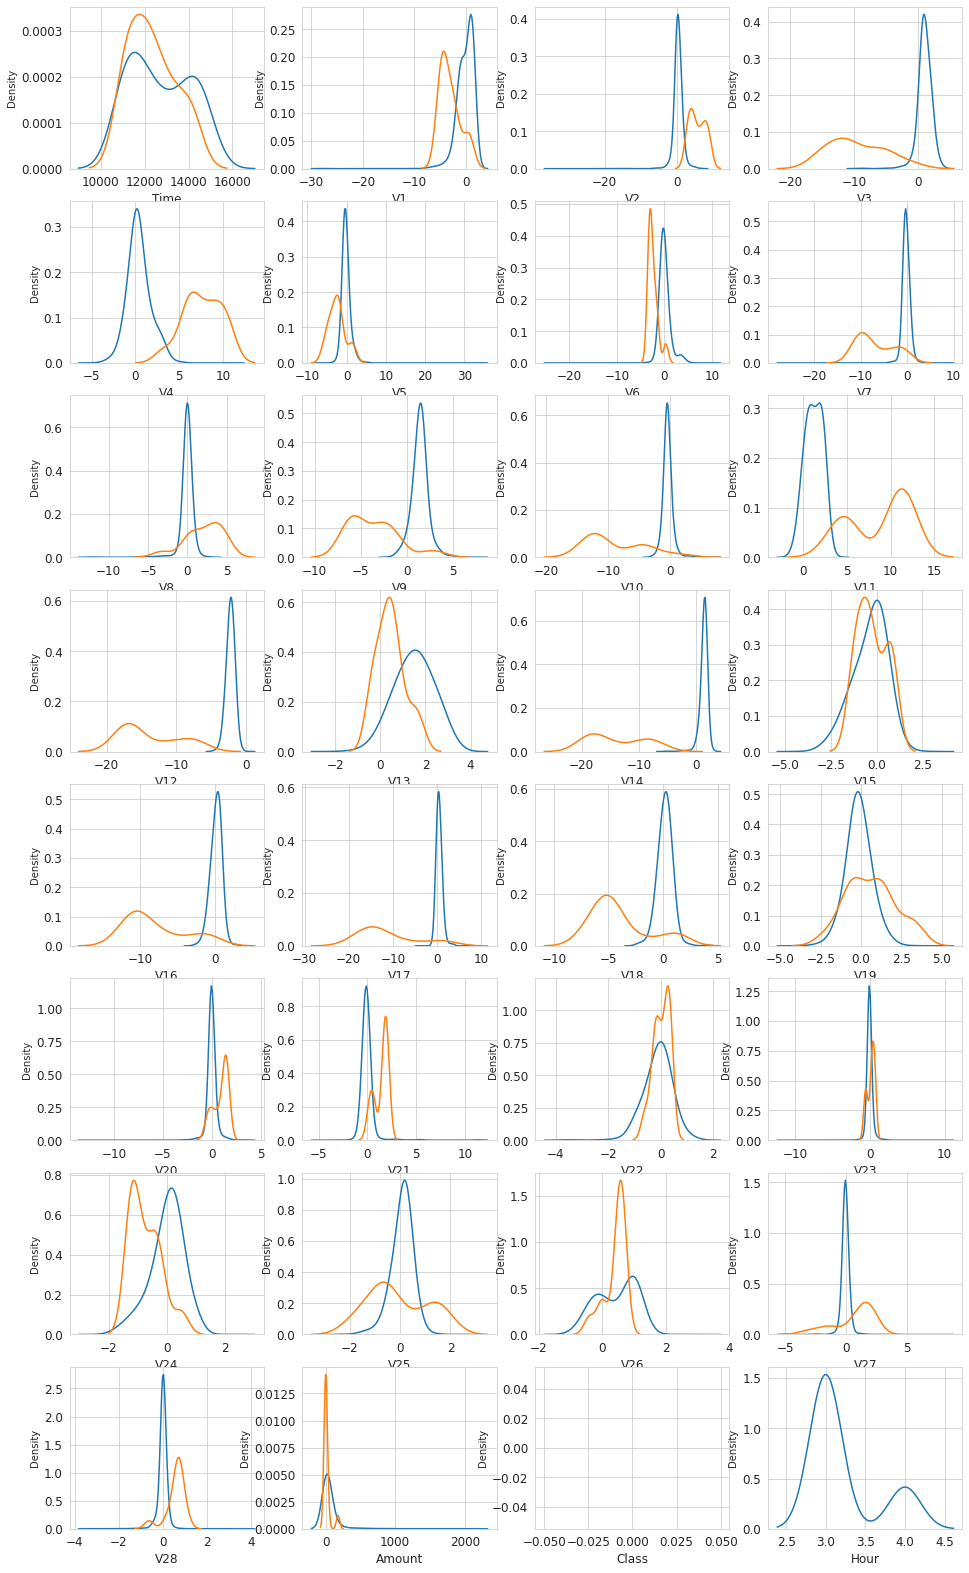

In [43]:
var = creditcard.columns.values

i = 0
t0 = creditcard.loc[creditcard['Class'] == 0]
t1 = creditcard.loc[creditcard['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

In [44]:
POSTGRES_PASSWORD = passwrd_parser(POSTGRES_PASSWORD)

In [45]:
creditcard["timestamp"] = pd.Series([dt.datetime.now()] * creditcard.shape[0])

In [46]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,timestamp
0,10990.0,-0.978969,0.891371,2.319535,-0.366443,-0.064428,-0.701253,0.287479,-0.277378,0.889065,-0.888369,0.798601,-1.864867,3.342448,0.979710,0.285233,0.255232,0.251996,0.114434,-0.141915,0.023812,0.016648,0.289814,-0.354844,0.451382,0.146643,1.035808,-0.285715,0.067639,12.95,0,3.0,2021-07-29 08:23:43.020347
1,10990.0,1.187976,-0.150266,0.950144,0.273609,-1.008121,-0.668541,-0.633928,0.013531,1.685281,-0.308360,2.273145,-2.391213,0.201110,1.976253,0.025093,0.692488,0.202148,0.763696,-0.181124,-0.170890,-0.018174,0.099565,0.014798,0.512315,0.099670,1.006098,-0.102534,-0.005459,15.95,0,3.0,2021-07-29 08:23:43.020347
2,10991.0,-0.291467,0.848939,1.853259,0.057920,-0.438931,-0.597373,0.200133,-0.201451,1.101389,-0.656723,0.579345,-2.494774,2.182849,1.318407,0.637624,0.084044,0.503039,0.362604,0.402474,0.037224,0.076264,0.488248,-0.076796,0.429956,-0.734458,1.011073,-0.056456,0.145633,14.95,0,3.0,2021-07-29 08:23:43.020347
3,10991.0,-0.362454,0.475100,1.579593,-0.891771,0.006748,-0.451606,0.167889,0.042788,1.157205,-0.903576,1.668824,-2.240497,1.240255,1.612326,-0.823729,0.956849,-0.359215,0.912083,-0.606932,-0.130137,0.117070,0.479416,-0.026288,-0.006762,-0.877070,0.752055,0.061740,0.160531,15.95,0,3.0,2021-07-29 08:23:43.020347
4,10992.0,1.345316,-0.018177,0.290022,-0.006065,-0.125986,-0.026471,-0.449742,-0.126617,1.794592,-0.525465,-0.567849,-2.696546,2.284918,1.341292,0.655219,0.883889,-0.228953,0.581675,0.122653,-0.019355,-0.155716,-0.168735,-0.191035,-0.980377,0.402362,1.116657,-0.089681,-0.007732,15.95,0,3.0,2021-07-29 08:23:43.020347


In [47]:
if train :
    write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,creditcard,TABLE_PREPROCESS_TRAIN)
elif inference :
    creditcard = creditcard.reset_index()
    write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,creditcard,TABLE_PREPROCESS_INFERENCE)